In [78]:
import os
import torch
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from tqdm import tnrange
from pathlib import Path

VIDEOS_BASE_DIR = "../data/Processed"
CONVERTED_VIDEOS_BASE_DIR = "../data/Converted2"

cpu = torch.device('cpu')
cuda = torch.device('cuda')

## Get file paths

In [6]:
all_file_names = os.listdir(VIDEOS_BASE_DIR)

In [7]:
video_file_names = [name for name in all_file_names if name[-4:] == ".mp4"]

In [8]:
video_file_names[0]

'17S2-BS1102-LEC_20180126.mp4'

In [9]:
video_file_paths = [os.path.join(VIDEOS_BASE_DIR, name) for name in video_file_names]

In [10]:
video_file_paths[0]

'../data/Processed/17S2-BS1102-LEC_20180126.mp4'

## Check video tensor dimensions

In [11]:
first_minute_tensor = tv.io.video.read_video(video_file_paths[0], start_pts=0, end_pts=60, pts_unit='sec')[0]
first_minute_tensor.shape

torch.Size([887, 480, 852, 3])

In [39]:
first_minute_tensor.dtype

torch.uint8

In [12]:
first_frame_tensor = first_minute_tensor[0]
first_frame_tensor.shape

torch.Size([480, 852, 3])

### Video tensor

The original video tensor format: F, H, W, C: <br>
F - number of images (frame) <br>
H - height <br>
W - width <br>
C - channels (3, rgb)

## Print frame

In [13]:
def rgb_frame_to_image(frame_tensor):
    # convert F,H,W,C to C,H,W format
    frame_tensor = frame_tensor.permute([2, 0, 1])
    return transforms.ToPILImage()(frame_tensor)

def grey_frame_to_image(frame_tensor):
    # convert H,W to C,H,W format by adding channel
    H = frame_tensor.shape[0]
    W = frame_tensor.shape[1]
    frame_tensor = frame_tensor.view(1, H, W)
    return transforms.ToPILImage()(frame_tensor)

In [14]:
first_frame_img = rgb_frame_to_image(first_frame_tensor)

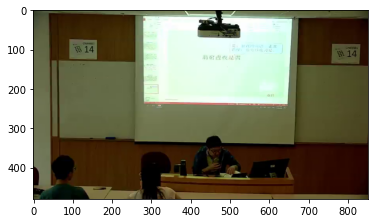

In [15]:
plt.imshow(first_frame_img)

## Grayscale image convertion

In [45]:
rgb_weights = [0.3, 0.59, 0.11]
first_frame_tensor_grey = first_frame_tensor.to(cuda) * torch.cuda.FloatTensor(rgb_weights)
first_frame_tensor_grey.shape

torch.Size([480, 852, 3])

In [46]:
first_frame_tensor_grey.dtype

torch.float32

In [47]:
first_frame_tensor_grey = first_frame_tensor_grey.sum(2)
first_frame_tensor_grey.shape

torch.Size([480, 852])

In [50]:
first_frame_tensor_grey = first_frame_tensor_grey.floor()

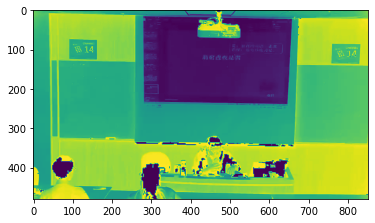

In [51]:
first_frame_grey_image = grey_frame_to_image(first_frame_tensor_grey)
plt.imshow(first_frame_grey_image)

## Grayscale video convertion

In [52]:
def greyscale(video_tensor):
    rgb_weights = [0.3, 0.59, 0.11]
    return (video_tensor.to(cuda) * torch.cuda.FloatTensor(rgb_weights).view(1,1,1,3)).sum(3).floor()

In [53]:
first_minute_tensor_grey = greyscale(first_minute_tensor)

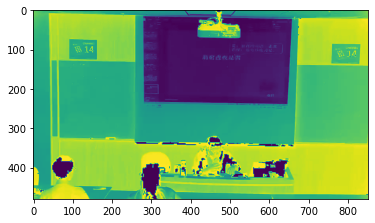

In [54]:
first_frame_grey_image = grey_frame_to_image(first_minute_tensor_grey[0])
plt.imshow(first_frame_grey_image)

## Video convertion

In [42]:
def convert_video(video_tensor):
    # Take every 16'th frame
    number_of_frames = video_tensor.shape[0]
    video_tensor = video_tensor[0:number_of_frames:16]
    video_tensor = video_tensor.float()
    
    # Take every 4'th pixel
    # F,H,W,C to F,C,H,W
    video_tensor = video_tensor.permute(0,3,1,2)
    video_tensor = nn.MaxPool2d(kernel_size=(1,1), stride=(4,4))(video_tensor)
    # to F,H,W,C
    video_tensor = video_tensor.permute(0,2,3,1)
    
    # To grayscale
    video_tensor = greyscale(video_tensor)
    
    return video_tensor

In [55]:
first_minute_converted = convert_video(first_minute_tensor)
print(first_minute_converted.dtype, first_minute_converted.shape)

torch.float32 torch.Size([56, 120, 213])


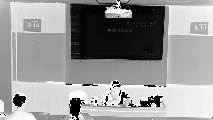

In [44]:
grey_frame_to_image(first_minute_converted[0])

## Load video in chunks

In [65]:
def load_video(video_path):
    metadata = VideoFileClip(video_path)
    duration = int(metadata.reader.duration // 10)
    
    video_chunks = []
    for index in tnrange(duration):
        start_pts = 10 * index
        end_pts = 10 * (index+1)
        video = tv.io.video.read_video(video_path, start_pts=start_pts, end_pts=end_pts, pts_unit='sec')[0]
        
        video = convert_video(video)
        video_chunks.append(video)
    return torch.cat(video_chunks, dim=0)

In [66]:
video = load_video(video_file_paths[0])
video.shape

torch.Size([7189, 120, 213])

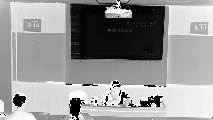

In [67]:
grey_frame_to_image(video[0])

In [70]:
base_name = os.path.basename(video_file_paths[0])
base_name

'17S2-BS1102-LEC_20180126.mp4'

In [73]:
output_path = os.path.join(CONVERTED_VIDEOS_BASE_DIR, base_name)
output_path

'../data/Converted2/17S2-BS1102-LEC_20180126.mp4'

In [79]:
Path(CONVERTED_VIDEOS_BASE_DIR).mkdir(parents=True, exist_ok=True)
torch.save(video, output_path[:-4] + ".pt")

## Convert all videos

In [ ]:
for video_path in video_file_paths:
    video = load_video(video_path)